In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import optuna
import vectorbtpro as vbt
vbt.settings.set_theme('dark')

import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
def backtest_strategy(data, short_window, long_window, vol_threshold):
    # Apply the strategy
    short_ma = data["Close"].rolling(window=short_window).mean()
    long_ma = data["Close"].rolling(window=long_window).mean()  # may want to use this

    # Conditions
    high_vol = data["Volatility"] > vol_threshold
    low_vol = ~high_vol
    up_trend = data["Close"] > short_ma
    down_trend = data["Close"] < short_ma

    entries = up_trend & low_vol
    short_entries = down_trend & low_vol
    exits = down_trend | high_vol
    short_exits = up_trend | high_vol

    pf = vbt.Portfolio.from_signals(
        close=data["Close"],
        entries=entries,
        exits=exits,
        short_entries=short_entries,
        short_exits=short_exits,
    )

    return pf


def objective(trial, data):
    short_window = trial.suggest_int("short_window", 1, 50)
    long_window = trial.suggest_int("long_window", 20, 200)

    if short_window >= long_window:
        return float("inf")

    vol_threshold = trial.suggest_float(
        "vol_threshold", data["Volatility"].min(), data["Volatility"].max(), step=0.05
    )

    pf = backtest_strategy(data, short_window, long_window, vol_threshold)

    return -pf.total_return


def create_labels(data, short_window, long_window, vol_threshold):
    short_ma = data["Close"].rolling(window=short_window).mean()
    long_ma = data["Close"].rolling(window=long_window).mean()  # may want to use this

    high_vol = data["Volatility"] > vol_threshold
    low_vol = ~high_vol
    up_trend = data["Close"] > short_ma
    down_trend = data["Close"] < short_ma

    labels = pd.Series(0, index=data.index)

    labels[up_trend & low_vol] = 1  # Low Volatility Uptrend
    labels[down_trend & low_vol] = -1  # Low Volatility Downtrend
    labels[up_trend & high_vol] = 0.5  # High Volatility Uptrend
    labels[down_trend & high_vol] = -0.5  # High Volatility Downtrend

    return labels


def plot_charts(pf):
    fig = pf.plot(
        subplots=[
            "orders",
            "trade_pnl",
            "cum_returns",
            "drawdowns",
            "underwater",
            "gross_exposure",
        ],
        make_subplots_kwargs=dict(
            rows=3,
            cols=2,
            shared_xaxes=True,
        ),
    )
    fig["layout"].update(height=800, width=1200)
    fig.show()


def plot_charts_with_heatmap(pf, data):
    # Create the subplots layout
    fig = pf.plot(
        subplots=[
            "orders",
            "trade_pnl",
            "cum_returns",
            "drawdowns",
            "underwater",
            "gross_exposure",
        ],
        make_subplots_kwargs=dict(
            rows=4,  # Adding an extra row for the heatmap
            cols=2,
            shared_xaxes=True,
            specs=[
                [{}, {}],
                [{}, {}],
                [{}, {}],
                [{"secondary_y": True}, None],
            ],  # Secondary y-axis enabled in the last row, first column
        ),
        subplot_settings=dict(
            cum_returns=dict(pct_scale=True),
            underwater=dict(pct_scale=True),
        ),
    )

    fig["layout"].update(height=800, width=1200)

    # Create the heatmap overlay
    data["Close"].vbt.overlay_with_heatmap(data["Labels"], title="Regime Overlay")

    fig.add_trace(
        data["Close"]
        .vbt.overlay_with_heatmap(data["Labels"], title="Regime Overlay")
        .data[0],
        row=4,
        col=1,
    )
    fig.add_trace(
        data["Close"]
        .vbt.overlay_with_heatmap(data["Labels"], title="Regime Overlay")
        .data[1],
        row=4,
        col=1,
        secondary_y=True,
    )
    fig.show()
    


In [4]:


# Data Download and Preparation
data = yf.download("ETH-USD", period="5y", interval="1d", auto_adjust=True)
data.to_csv("ETH-daily.csv")


/Users/ericervin/miniforge3/envs/py311/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [60]:
vol_window = 30

data['Return'] = data['Close'].pct_change()
data['Volatility'] = data['Return'].rolling(window=vol_window).std() * np.sqrt(365)
# Optimize the strategy
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, data), n_trials=1000)

# Print the best parameters
best_params = study.best_params
print('Best parameters: ', best_params)
print('Best value: ', study.best_value)

# Backtest with the best parameters
best_pf = backtest_strategy(
    data,
    best_params['short_window'],
    best_params['long_window'],
    best_params['vol_threshold']
)

# Create and assign labels
data['Labels'] = create_labels(data, 
                               best_params['short_window'], 
                               best_params['long_window'], 
                               best_params['vol_threshold'])


# Compare it to a buy and hold strategy
buy_hold_pf = vbt.Portfolio.from_holding(data['Close'])

comparison = pd.concat({
    'Optimized': best_pf.stats(),
    'Buy and Hold': buy_hold_pf.stats()
}, axis=1)

# print("Label Counts")
# print(data['Labels'].value_counts())

print(comparison)

# Plot the charts with the heatmap overlay
plot_charts_with_heatmap(best_pf, data)


[I 2024-07-29 15:20:03,089] A new study created in memory with name: no-name-1bdf85ca-f9b1-4df0-93c8-ccb45f649eb5
[I 2024-07-29 15:20:03,113] Trial 0 finished with value: 0.34098053483987173 and parameters: {'short_window': 3, 'long_window': 44, 'vol_threshold': 2.053961790137404}. Best is trial 0 with value: 0.34098053483987173.
[I 2024-07-29 15:20:03,121] Trial 1 finished with value: -0.2898958570691701 and parameters: {'short_window': 8, 'long_window': 110, 'vol_threshold': 0.35396179013740386}. Best is trial 1 with value: -0.2898958570691701.
[I 2024-07-29 15:20:03,128] Trial 2 finished with value: -6.3287333227715745 and parameters: {'short_window': 33, 'long_window': 101, 'vol_threshold': 1.0539617901374039}. Best is trial 2 with value: -6.3287333227715745.
[I 2024-07-29 15:20:03,136] Trial 3 finished with value: -2.397891700254894 and parameters: {'short_window': 24, 'long_window': 110, 'vol_threshold': 1.353961790137404}. Best is trial 2 with value: -6.3287333227715745.
[I 2024

Best parameters:  {'short_window': 16, 'long_window': 25, 'vol_threshold': 1.703961790137404}
Best value:  -35.261336956966105
                                             Optimized         Buy and Hold
Start Index                        2019-07-29 00:00:00  2019-07-29 00:00:00
End Index                          2024-07-29 00:00:00  2024-07-29 00:00:00
Total Duration                      1828 days 00:00:00   1828 days 00:00:00
Start Value                                      100.0                100.0
Min Value                                    87.568347            52.353336
Max Value                                  5027.538365          2277.716567
End Value                                  3626.133696          1586.518118
Total Return [%]                           3526.133696          1486.518118
Benchmark Return [%]                       1486.518118          1486.518118
Position Coverage [%]                        96.115974                100.0
Max Gross Exposure [%]               

In [61]:
data.describe()

Open         High          Low        Close        Volume  \
count  1828.000000  1828.000000  1828.000000  1828.000000  1.828000e+03   
mean   1750.312322  1797.391641  1699.028631  1751.823894  1.534221e+10   
std    1205.077588  1237.927405  1167.633092  1204.722447  9.802678e+09   
min     110.406784   116.021622    95.184303   110.605873  2.081626e+09   
25%     421.841133   432.823524   407.226448   427.214119  8.297196e+09   
50%    1719.733337  1762.315002  1672.784424  1721.865662  1.323884e+10   
75%    2619.389893  2713.325745  2532.042542  2620.562683  1.916922e+10   
max    4810.071289  4891.704590  4718.039062  4812.087402  8.448291e+10   

            Return   Volatility       Labels  
count  1827.000000  1798.000000  1828.000000  
mean      0.002469     0.760721     0.065646  
std       0.043247     0.328548     0.982363  
min      -0.423472     0.153962    -1.000000  
25%      -0.017228     0.539178    -1.000000  
50%       0.001012     0.705871     1.000000  
75%       0.022392     0.894800     1.000000  
max       0.259475     2.106123     1.000000

# Now do this independently

In [62]:
def backtest_ma(data, short_window, long_window):
    # Apply the strategy
    short_ma = data['Close'].rolling(window=short_window).mean()
    long_ma = data['Close'].rolling(window=long_window).mean() # may want to use this 
    
    # Conditions 

    up_trend = short_ma > long_ma
    down_trend = short_ma < long_ma
    
    entries = up_trend
    short_entries = down_trend
    
    pf = vbt.Portfolio.from_signals(
        close=data['Close'],
        entries=entries,
        short_entries=short_entries,
    )
    
    return pf

def backtest_ma_twitchy(data, short_window, long_window):
    # Apply the strategy
    short_ma = data['Close'].rolling(window=short_window).mean()
    long_ma = data['Close'].rolling(window=long_window).mean() # may want to use this 
    
    # Conditions 

    up_trend = short_ma > long_ma
    down_trend = short_ma < long_ma
    
    entries = up_trend
    exits = down_trend | data['Close'] < short_ma # may want to change to long_ma
    short_entries = down_trend
    short_exits = up_trend | data['Close'] > short_ma # may want to change to long_ma
    
    pf = vbt.Portfolio.from_signals(
        close=data['Close'],
        entries=entries,
        exits=exits,
        short_entries=short_entries,
        short_exits=short_exits,
    )
    
    return pf

def objective_ma(trial, data):
    short_window = trial.suggest_int('short_window', 1, 50)
    long_window = trial.suggest_int('long_window', 20, 200)
    
    if short_window >= long_window:
        return float('inf')
    
    pf = backtest_ma(data, short_window, long_window)
    
    return -pf.total_return

In [63]:


data['Return'] = data['Close'].pct_change()

# Optimize the strategy
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_ma(trial, data), n_trials=1000)

# Print the best parameters
best_params = study.best_params
print('Best parameters: ', best_params)
print('Best value: ', study.best_value)

# Backtest with the best parameters
best_pf = backtest_ma(
    data,
    best_params['short_window'],
    best_params['long_window'],
)

# Compare it to a buy and hold strategy
buy_hold_pf = vbt.Portfolio.from_holding(data['Close'])

comparison = pd.concat({
    'Optimized': best_pf.stats(),
    'Buy and Hold': buy_hold_pf.stats()
}, axis=1)

print(comparison)
plot_charts(best_pf)




[I 2024-07-29 15:20:26,779] A new study created in memory with name: no-name-0901cf4c-85ae-4633-a31e-d0c9e55f3016
[I 2024-07-29 15:20:26,781] Trial 0 finished with value: inf and parameters: {'short_window': 24, 'long_window': 21}. Best is trial 0 with value: inf.
[I 2024-07-29 15:20:26,790] Trial 1 finished with value: 0.031553562001501806 and parameters: {'short_window': 42, 'long_window': 130}. Best is trial 1 with value: 0.031553562001501806.
[I 2024-07-29 15:20:26,800] Trial 2 finished with value: -1.2148072892210053 and parameters: {'short_window': 24, 'long_window': 192}. Best is trial 2 with value: -1.2148072892210053.
[I 2024-07-29 15:20:26,808] Trial 3 finished with value: 0.24136114328619215 and parameters: {'short_window': 36, 'long_window': 155}. Best is trial 2 with value: -1.2148072892210053.
[I 2024-07-29 15:20:26,819] Trial 4 finished with value: 0.40124181297690265 and parameters: {'short_window': 42, 'long_window': 153}. Best is trial 2 with value: -1.214807289221005

Best parameters:  {'short_window': 12, 'long_window': 20}
Best value:  -26.312659299810477
                                             Optimized         Buy and Hold
Start Index                        2019-07-29 00:00:00  2019-07-29 00:00:00
End Index                          2024-07-29 00:00:00  2024-07-29 00:00:00
Total Duration                      1828 days 00:00:00   1828 days 00:00:00
Start Value                                      100.0                100.0
Min Value                                    87.572484            52.353336
Max Value                                  5422.802888          2277.716567
End Value                                   2731.26593          1586.518118
Total Return [%]                            2631.26593          1486.518118
Benchmark Return [%]                       1486.518118          1486.518118
Position Coverage [%]                        98.960613                100.0
Max Gross Exposure [%]                      204.605257                100

In [64]:
# The `best_pf.value` attribute contains equity curve of the portfolio
best_pf.value.vbt.plot().show()

# Let's evaluate periods of weaker performance
best_pf.plot_underwater(pct_scale=True).show()
best_pf.plot_drawdowns().show()


In [101]:
open = best_pf.value
high = best_pf.value
low = best_pf.value
close = best_pf.value

upth = 0.15
downth = 0.15
simulation_data = pd.concat([open, high, low, close], axis=1)

simulation_data.columns = ["Open", "High", "Low", "Close"]
trendlb = vbt.Data.from_data(simulation_data).run("trendlb",up_th=upth, down_th=downth)
trendlb.plot().show()

In [102]:
simulation_data.shape

(1828, 4)

Run some tuneta to identify features that correlate with the regime

In [103]:
# Cell 1: Importing necessary libraries and setting up configurations
import logging
from tuneta.tune_ta import TuneTA

from sklearn.model_selection import train_test_split
import yfinance as yf
import warnings

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Filter out warnings
warnings.filterwarnings('ignore')

In [104]:
data

Open         High          Low        Close       Volume  \
Date                                                                          
2019-07-29   211.123657   213.932053   208.764313   211.268051   5485190664   
2019-07-30   211.339203   213.614075   206.867615   210.522598   5489918859   
2019-07-31   210.492416   218.654144   210.437912   218.654144   6003828340   
2019-08-01   218.554596   218.812653   212.914505   217.808441   5965442642   
2019-08-02   217.884460   222.182571   215.975830   217.871567   6159440229   
...                 ...          ...          ...          ...          ...   
2024-07-25  3336.362305  3341.438477  3088.764404  3174.427246  25293745810   
2024-07-26  3174.051025  3285.760986  3172.777100  3275.951416  15993893521   
2024-07-27  3275.891602  3327.426514  3195.356689  3247.607910  15198233287   
2024-07-28  3247.507324  3283.152100  3201.763184  3271.464600   8959236446   
2024-07-29  3270.651367  3395.257568  3264.668945  3351.805908  17853104128   

              Return  Volatility  Labels  
Date                                      
2019-07-29       NaN         NaN     0.0  
2019-07-30 -0.003528         NaN     0.0  
2019-07-31  0.038626         NaN     0.0  
2019-08-01 -0.003868         NaN     0.0  
2019-08-02  0.000290         NaN     0.0  
...              ...         ...     ...  
2024-07-25 -0.048530    0.563425    -1.0  
2024-07-26  0.031982    0.575115    -1.0  
2024-07-27 -0.008652    0.569753    -1.0  
2024-07-28  0.007346    0.566283    -1.0  
2024-07-29  0.024558    0.573046    -1.0  

[1828 rows x 8 columns]

In [107]:
X = data.copy()
y = trendlb.labels

# Ensure both indices are localized to UTC timezone if they are naive
if X.index.tzinfo is None:
    X.index = X.index.tz_localize('UTC')

if y.index.tzinfo is None:
    y.index = y.index.tz_localize('UTC')

# Convert to naive datetime (remove timezone info)
X.index = X.index.tz_convert('UTC').tz_localize(None)
y.index = y.index.tz_convert('UTC').tz_localize(None)

# Drop rows where all columns are NaN
X = X.dropna(how='all')
y = y.dropna(how='all')

# Debugging: Check the shapes and indices after conversion
print(f"Shapes after conversion: X - {X.shape}, y - {y.shape}")
print(f"X index head: {X.index[:5]}, y index head: {y.index[:5]}")

# Set the intersection of the indices
idx_union = X.index.intersection(y.index)
print(f"Intersecting indices: {len(idx_union)}")

X = X.loc[idx_union]
y = y.loc[idx_union]

# Final check for empty data
print(f"Final X shape: {X.shape}, y shape: {y.shape}")

# Remove rows with NaN values in 'Return' and 'Volatility'
X.dropna(subset=['Return', 'Volatility'], inplace=True)

# Align y with X after dropping rows in X
y = y.loc[X.index]

# Final check for NaN values and shape consistency
if X.isna().sum().sum() > 0 or y.isna().sum() > 0:
    logging.error("There are still NaN values in the data after alignment. Please check the data.")
elif len(X) != len(y):
    logging.error("X and y have different lengths after alignment. Please check the data.")
else:
    logging.info("Data is clean and ready for TuneTA optimization.")

    # Initializing and optimizing TuneTA
    logging.info("Initializing TuneTA.")
    tt = TuneTA(n_jobs=16, verbose=True)

    logging.info("Optimizing TuneTA.")
    tt.fit(X, y,
        indicators=['tta'],
        ranges=[(4, 100)],
        trials=100,
        early_stop=25,
    )
    logging.info("Optimization complete.")

    # Displaying fit times and generating correlation reports
    tt.fit_times()
    logging.info("Generating final report on correlation of indicators.")
    tt.report(target_corr=True, features_corr=True)
    
features = tt.transform(X)
features

2024-07-29 16:32:35,308 - INFO - Data is clean and ready for TuneTA optimization.
2024-07-29 16:32:35,308 - INFO - Initializing TuneTA.
2024-07-29 16:32:35,309 - INFO - Optimizing TuneTA.


Shapes after conversion: X - (1828, 8), y - (1823,)
X index head: DatetimeIndex(['2019-07-29', '2019-07-30', '2019-07-31', '2019-08-01',
               '2019-08-02'],
              dtype='datetime64[ns]', name='Date', freq=None), y index head: DatetimeIndex(['2019-07-29', '2019-07-30', '2019-07-31', '2019-08-01',
               '2019-08-02'],
              dtype='datetime64[ns]', name='Date', freq=None)
Intersecting indices: 1823
Final X shape: (1823, 8), y shape: (1823,)


2024-07-29 16:32:41,533 - INFO - Optimization complete.
2024-07-29 16:32:41,536 - INFO - Generating final report on correlation of indicators.


     Indicator                  Times
---  -----------------------  -------
 54  tta.MACD                    2.84
 19  tta.APO                     2.83
 24  tta.MACDEXT                 2.65
 48  tta.ULTOSC                  2.15
 52  tta.ADOSC                   2.12
 42  tta.PPO                     2.03
  3  tta.STOCHRSI                2.03
 34  tta.CMO                     1.94
 35  tta.CCI                     1.9
 16  tta.TEMA                    1.84
 41  tta.MFI                     1.81
 13  tta.EMA                     1.81
 27  tta.WILLR                   1.77
  0  tta.DX                      1.74
  7  tta.WMA                     1.73
 29  tta.MINUS_DI                1.71
 32  tta.MINUS_DM                1.68
 18  tta.BBANDS                  1.6
 33  tta.RSI                     1.56
 51  tta.STOCH                   1.47
 55  tta.MOM                     1.47
 58  tta.TRIX                    1.46
 43  tta.PLUS_DI                 1.46
 49  tta.ADX                     1.42
 57  tta.NATR 

tta_DX_timeperiod_16  tta_T3_timeperiod_91  tta_TSF_timeperiod_75  \
Date                                                                            
2019-08-28                   NaN                   NaN                    NaN   
2019-08-29                   NaN                   NaN                    NaN   
2019-08-30                   NaN                   NaN                    NaN   
2019-08-31                   NaN                   NaN                    NaN   
2019-09-01                   NaN                   NaN                    NaN   
...                          ...                   ...                    ...   
2024-07-20              8.456339           3610.530374            3395.549327   
2024-07-21              0.335862           3611.064028            3390.894814   
2024-07-22              1.908201           3611.469097            3379.623948   
2024-07-23              1.821215           3611.755416            3371.796297   
2024-07-24             12.139340           3611.925070            3352.215586   

            tta_STOCHRSI_timeperiod_30_fastk_period_46_fastd_period_39_0  \
Date                                                                       
2019-08-28                                                NaN              
2019-08-29                                                NaN              
2019-08-30                                                NaN              
2019-08-31                                                NaN              
2019-09-01                                                NaN              
...                                                       ...              
2024-07-20                                          70.184128              
2024-07-21                                          77.192065              
2024-07-22                                          75.264769              
2024-07-23                                          81.051495              
2024-07-24                                          59.699966              

            tta_STOCHRSI_timeperiod_30_fastk_period_46_fastd_period_39_1  \
Date                                                                       
2019-08-28                                                NaN              
2019-08-29                                                NaN              
2019-08-30                                                NaN              
2019-08-31                                                NaN              
2019-09-01                                                NaN              
...                                                       ...              
2024-07-20                                          30.950868              
2024-07-21                                          31.754739              
2024-07-22                                          32.804896              
2024-07-23                                          33.968007              
2024-07-24                                          34.312031              

            tta_LINEARREG_timeperiod_81  tta_TRIMA_timeperiod_65  \
Date                                                               
2019-08-28                          NaN                      NaN   
2019-08-29                          NaN                      NaN   
2019-08-30                          NaN                      NaN   
2019-08-31                          NaN                      NaN   
2019-09-01                          NaN                      NaN   
...                                 ...                      ...   
2024-07-20                  3443.915815              3502.952669   
2024-07-21                  3440.886111              3493.075336   
2024-07-22                  3433.135279              3482.661587   
2024-07-23                  3429.840213              3471.864707   
2024-07-24                  3419.488467              3460.494853   

            tta_HT_TRENDLINE  tta_WMA_timeperiod_67  tta_MA_timeperiod_67  \
Date              

```
Indicator Correlation to Target:

                                                              Correlation
----------------------------------------------------------  -------------
tta_STOCHRSI_timeperiod_34_fastk_period_53_fastd_period_34       0.153597
tta_STOCHF_fastk_period_45_fastd_period_73                       0.145361
tta_WILLR_timeperiod_55                                          0.132725
tta_CMO_timeperiod_10                                            0.12267
tta_RSI_timeperiod_10                                            0.12267
tta_CCI_timeperiod_62                                            0.121588
tta_MFI_timeperiod_18                                            0.111284
tta_T3_timeperiod_96                                             0.111026
tta_MINUS_DI_timeperiod_16                                       0.108391
tta_PPO_fastperiod_89_slowperiod_91                              0.107916
tta_LINEARREG_ANGLE_timeperiod_43                                0.102488
tta_PLUS_DI_timeperiod_10                                        0.101051
tta_MACDEXT_fastperiod_94_slowperiod_90_signalperiod_36          0.100727
tta_ULTOSC_timeperiod1_26_timeperiod2_14_timeperiod3_9           0.099749
tta_APO_fastperiod_88_slowperiod_91                              0.096309
tta_DX_timeperiod_87                                             0.092525
tta_AROONOSC_timeperiod_22                                       0.089656
```

In [96]:
vbt.phelp(vbt.indicator('stochf').run)


STOCHF.run(
    high,
    low,
    close,
    fastk_period=Default(value=5),
    fastd_period=Default(value=3),
    fastd_matype=Default(value=0),
    timeframe=Default(value=None),
    short_name='stochf',
    hide_params=None,
    hide_default=True,
    **kwargs
):
    Run `STOCHF` indicator.
    
    * Inputs: `high`, `low`, `close`
    * Parameters: `fastk_period`, `fastd_period`, `fastd_matype`, `timeframe`
    * Outputs: `fastk`, `fastd`
    
    Pass a list of parameter names as `hide_params` to hide their column levels, or True to hide all.
    Set `hide_default` to False to show the column levels of the parameters with a default value.
    
    Other keyword arguments are passed to `STOCHF.run_pipeline`.


In [92]:
vbt.IF.list_indicators("stochrsi")
vbt.phelp(vbt.indicator('stochrsi').run)

STOCHRSI.run(
    close,
    timeperiod=Default(value=14),
    fastk_period=Default(value=5),
    fastd_period=Default(value=3),
    fastd_matype=Default(value=0),
    timeframe=Default(value=None),
    short_name='stochrsi',
    hide_params=None,
    hide_default=True,
    **kwargs
):
    Run `STOCHRSI` indicator.
    
    * Inputs: `close`
    * Parameters: `timeperiod`, `fastk_period`, `fastd_period`, `fastd_matype`, `timeframe`
    * Outputs: `fastk`, `fastd`
    
    Pass a list of parameter names as `hide_params` to hide their column levels, or True to hide all.
    Set `hide_default` to False to show the column levels of the parameters with a default value.
    
    Other keyword arguments are passed to `STOCHRSI.run_pipeline`.


In [115]:
# vbt.phelp(vbt.ADX.run)
# vbt.phelp(vbt.STOCH.run)

stochrsi = vbt.indicator('STOCHRSI').run(data['Close'], timeperiod=34, fastk_period=53, fastd_period=34)
stochf = vbt.indicator('STOCHF').run(data['High'], data['Low'], data['Close'], fastk_period=45, fastd_period=73)

stochrsi.plot().show()
stochf.plot().show()


In [116]:

# Plot the regimes where the strategy did well and poorly

grouper = pd.Index(trendlb.labels.map({1: "U", 0: "D"}), name="trend")
trend_splitter = vbt.Splitter.from_grouper(simulation_data.index, grouper)
trend_splitter.plot().show()

Let's do this more programmatically with all the top 10 features that are most closely associated with our target regime filter.

In [117]:
# Assuming 'features' contains the newly added columns that might have NaNs
top_ten_features = features.columns[:10]
top_ten = features[top_ten_features]

# Concatenate the new features to the original DataFrame
X = pd.concat([X, top_ten], axis=1)

# Create a mask for rows where none of the new feature columns have NaN values
non_na_mask = top_ten.notna().all(axis=1)

# Apply the mask to filter the DataFrame and the target variable
X_filtered = X[non_na_mask]
y_filtered = y[non_na_mask]

# Check the resulting shapes to confirm filtering
print(X_filtered.shape, y_filtered.shape)

(1253, 38) (1253,)


In [122]:
import dcor
import pandas as pd

# Recalculate distance correlation
dist_corr = {}
for column in X_filtered.columns:
    dist_corr[column] = dcor.distance_correlation(X_filtered[column].values, y_filtered.values)

# Convert the dictionary to a pandas Series for easy viewing
dist_corr_series = pd.Series(dist_corr).sort_values(ascending=False)

# Print the distance correlation values
print(dist_corr_series)


tta_DX_timeperiod_16                                            0.317246
tta_T3_timeperiod_91                                            0.256100
tta_STOCHRSI_timeperiod_30_fastk_period_46_fastd_period_39_0    0.240939
low                                                             0.223297
close                                                           0.217098
open                                                            0.216319
high                                                            0.211226
tta_HT_TRENDLINE                                                0.192173
tta_MA_timeperiod_67                                            0.185433
tta_WMA_timeperiod_67                                           0.178801
tta_TRIMA_timeperiod_65                                         0.173191
tta_TSF_timeperiod_75                                           0.170746
tta_LINEARREG_timeperiod_81                                     0.166693
tta_STOCHRSI_timeperiod_30_fastk_period_46_fastd_pe

In [132]:
print(f"Length of X_filtered: {len(X_filtered)}")
print(f"Length of y_filtered: {len(y_filtered)}")

Length of X_filtered: 1253
Length of y_filtered: 1253


In [131]:
X_filtered['tta_DX_timeperiod_16']

Date
2021-02-18    30.302028
2021-02-19    32.057208
2021-02-20    37.739287
2021-02-21    37.739287
2021-02-22     4.454473
                ...    
2024-07-20     8.456339
2024-07-21     0.335862
2024-07-22     1.908201
2024-07-23     1.821215
2024-07-24    12.139340
Name: tta_DX_timeperiod_16, Length: 1253, dtype: float64

In [127]:
# Display all column names to check for duplicates
print(X_filtered.columns)

# Alternatively, check for duplicated columns programmatically
duplicates = X_filtered.columns[X_filtered.columns.duplicated()]
print("Duplicated columns:", duplicates)

# Drop duplicated columns
# Drop duplicated columns while keeping the first instance
X_filtered = X_filtered.loc[:, ~X_filtered.columns.duplicated()]

# Verify the column names are unique
print(X_filtered.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'return', 'volatility',
       'labels', 'tta_DX_timeperiod_16', 'tta_T3_timeperiod_91',
       'tta_TSF_timeperiod_75',
       'tta_STOCHRSI_timeperiod_30_fastk_period_46_fastd_period_39_0',
       'tta_STOCHRSI_timeperiod_30_fastk_period_46_fastd_period_39_1',
       'tta_LINEARREG_timeperiod_81', 'tta_TRIMA_timeperiod_65',
       'tta_HT_TRENDLINE', 'tta_WMA_timeperiod_67', 'tta_MA_timeperiod_67',
       'tta_DX_timeperiod_16', 'tta_T3_timeperiod_91', 'tta_TSF_timeperiod_75',
       'tta_STOCHRSI_timeperiod_30_fastk_period_46_fastd_period_39_0',
       'tta_STOCHRSI_timeperiod_30_fastk_period_46_fastd_period_39_1',
       'tta_LINEARREG_timeperiod_81', 'tta_TRIMA_timeperiod_65',
       'tta_HT_TRENDLINE', 'tta_WMA_timeperiod_67', 'tta_MA_timeperiod_67',
       'tta_DX_timeperiod_16', 'tta_T3_timeperiod_91', 'tta_TSF_timeperiod_75',
       'tta_STOCHRSI_timeperiod_30_fastk_period_46_fastd_period_39_0',
       'tta_STOCHRSI_timeperiod_3

2024-07-30 16:55:09,508 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-30 16:55:09,512 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


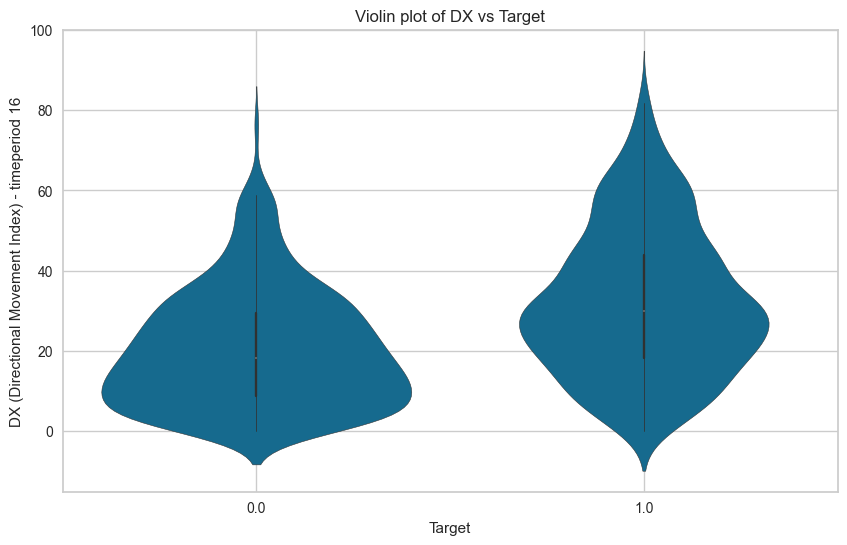

In [133]:
# Violin plot of 'tta_DX_timeperiod_16' with the binary target
plt.figure(figsize=(10, 6))
sns.violinplot(x=y_filtered, y=X_filtered['tta_DX_timeperiod_16'])
plt.xlabel('Target')
plt.ylabel('DX (Directional Movement Index) - timeperiod 16')
plt.title('Violin plot of DX vs Target')
plt.grid(True)
plt.show()

In [159]:
entries = X_filtered['tta_DX_timeperiod_16'] > 30
exits = X_filtered['tta_DX_timeperiod_16'] < 20
meta_index = X_filtered.index
pf = vbt.Portfolio.from_signals(
    close=best_pf[meta_index].value,
    entries=entries,
    exits=exits,
)
display(pf.stats())
pf.plot().show()

Start Index                          2021-02-18 00:00:00
End Index                            2024-07-24 00:00:00
Total Duration                        1253 days 00:00:00
Start Value                                        100.0
Min Value                                      67.994575
Max Value                                      187.80943
End Value                                     148.580598
Total Return [%]                               48.580598
Benchmark Return [%]                          -25.642294
Position Coverage [%]                          47.406225
Max Gross Exposure [%]                             100.0
Max Drawdown [%]                               53.033166
Max Drawdown Duration                 1023 days 00:00:00
Total Orders                                         104
Total Fees Paid                                      0.0
Total Trades                                          52
Win Rate [%]                                   42.307692
Best Trade [%]                 

2024-07-30 17:09:06,319 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-30 17:09:06,324 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


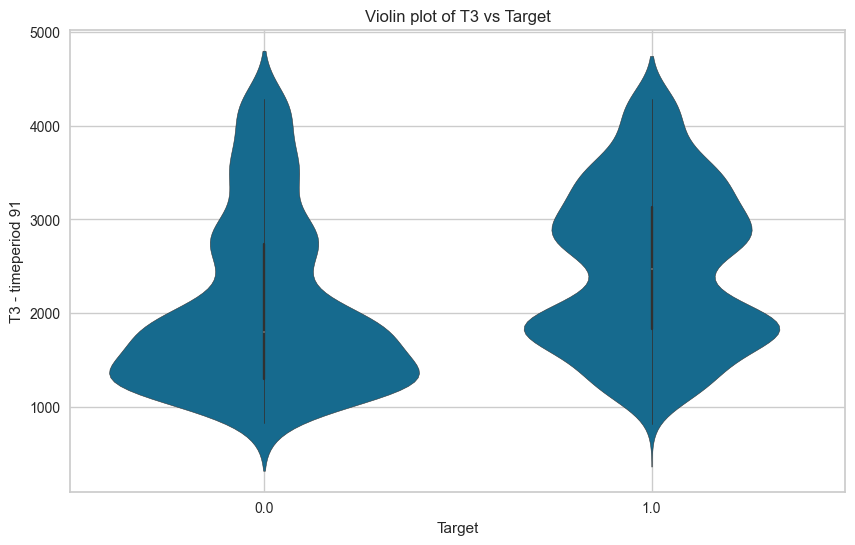

In [153]:
# Violin plot of 'tta_DX_timeperiod_16' with the binary target
plt.figure(figsize=(10, 6))
sns.violinplot(x=y_filtered, y=X_filtered['tta_T3_timeperiod_91'])
plt.xlabel('Target')
plt.ylabel('T3 - timeperiod 91')
plt.title('Violin plot of T3 vs Target')
plt.grid(True)
plt.show()

In [162]:
entries = X_filtered['tta_T3_timeperiod_91'] > 2500
exits = X_filtered['tta_T3_timeperiod_91'] < 2000
meta_index = X_filtered.index
pf = vbt.Portfolio.from_signals(
    close=best_pf[meta_index].value,
    entries=entries,
    exits=exits,
)
display(pf.stats())
pf.plot().show()

Start Index                   2021-02-18 00:00:00
End Index                     2024-07-24 00:00:00
Total Duration                 1253 days 00:00:00
Start Value                                 100.0
Min Value                               61.605023
Max Value                              505.047823
End Value                              388.796679
Total Return [%]                       288.796679
Benchmark Return [%]                   -25.642294
Position Coverage [%]                   42.537909
Max Gross Exposure [%]                      100.0
Max Drawdown [%]                        48.065872
Max Drawdown Duration           611 days 00:00:00
Total Orders                                    3
Total Fees Paid                               0.0
Total Trades                                    2
Win Rate [%]                                100.0
Best Trade [%]                         237.451822
Worst Trade [%]                        237.451822
Avg Winning Trade [%]                  237.451822


In [152]:
hold_pf = vbt.Portfolio.from_holding(data)
hold_returns_acc = hold_pf.returns_acc

fast_sma, slow_sma = vbt.talib("SMA").run_combs(
    data.Close, np.arange(5, 50), short_names=["fast_sma", "slow_sma"])
entries = fast_sma.real_crossed_above(slow_sma)
exits = fast_sma.real_crossed_below(slow_sma)
strat_pf = vbt.Portfolio.from_signals(
    data, entries, exits, direction="both")
strat_returns_acc = strat_pf.returns_acc

In [153]:
hold_returns_acc_slices = trend_splitter.take(hold_returns_acc)
strat_returns_acc_slices = trend_splitter.take(strat_returns_acc)

In [154]:
# print(hold_returns_acc_slices["U"].sharpe_ratio())


strat_returns_acc_slices["U"].sharpe_ratio().vbt.heatmap(
    x_level="fast_sma_timeperiod", 
    y_level="slow_sma_timeperiod",
    symmetric=True,
    height=200, width=300,
    title="Sharpe Ratio (Up Periods)"
).show()

# print(strat_returns_acc_slices["D"].sharpe_ratio())

strat_returns_acc_slices["D"].sharpe_ratio().vbt.heatmap(
    x_level="fast_sma_timeperiod", 
    y_level="slow_sma_timeperiod",
    symmetric=True,
    height=200, width=300,
    title="Sharpe Ratio (Down Periods)"
).show()

/Users/ericervin/miniforge3/envs/py311/lib/python3.11/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



/Users/ericervin/miniforge3/envs/py311/lib/python3.11/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



# Working with PivotInfo

In [134]:
upth = 0.1
downth = 0.10

pivotinfo = vbt.Data.from_data(simulation_data).run("pivotinfo", up_th=upth, down_th=downth)
simulation_data['conf_pivot'], simulation_data['last_pivot'] = pivotinfo.conf_value, pivotinfo.last_value
fig = pivotinfo.plot()
simulation_data.Close.vbt.plot(fig=fig).show()